In [65]:
!pip install opencv-python==4.12.0.88 mediapipe==0.10.14

## Pose Detection 부분

In [66]:
import math
import cv2
import numpy as np
from time import time
from mediapipe.python.solutions import pose as mp_pose
from mediapipe.python.solutions import drawing_utils as mp_drawing
import matplotlib.pyplot as plt


POSE_MODEL = mp_pose.Pose(
    static_image_mode=True,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.6,
    model_complexity=2
)


## Pose detection - Improved Version

def detectPose_improve(image, pose, display=True):

    # 이미지 복사
    output_image = image.copy()

    # BGR → RGB 변환
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Pose detection 수행
    results = pose.process(imageRGB)

    # 이미지 크기
    height, width, _ = image.shape

    # landmark 리스트 초기화
    landmarks = []

    # landmark 감지 시
    if results.pose_landmarks:

        # landmark 그리기
        mp_drawing.draw_landmarks(
            image=output_image,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS
        )

        # landmark 좌표 저장
        for landmark in results.pose_landmarks.landmark:
            lx = int(landmark.x * width)
            ly = int(landmark.y * height)
            lz = landmark.z
            landmarks.append((lx, ly, lz))

    # 화면 출력 모드일 때
    if display:

        # 원본 및 결과 비교 시각화
        plt.figure(figsize=[22, 22])
        plt.subplot(121)
        plt.imshow(image[:, :, ::-1])
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(output_image[:, :, ::-1])
        plt.title("Output Image")
        plt.axis('off')

        # 안전한 3D world landmark 출력
        if results.pose_world_landmarks:
            mp_drawing.plot_landmarks(
                results.pose_world_landmarks,
                mp_pose.POSE_CONNECTIONS,
                azimuth=45
            )
        else:
            print("World landmarks not detected.")

    # display=False일 때는 return
    return output_image, landmarks


In [67]:
# 상·하의 피팅 기준 핵심 landmark
KEY_LANDMARKS = {
    # 얼굴 기준점 (정렬용)
    "nose": 0,

    # 상의 (어깨, 팔)
    "left_shoulder": 11,
    "right_shoulder": 12,
    "left_elbow": 13,
    "right_elbow": 14,
    "left_wrist": 15,
    "right_wrist": 16,

    # 하의 (골반, 다리)
    "left_hip": 23,
    "right_hip": 24,
    "left_knee": 25,
    "right_knee": 26,
    "left_ankle": 27,
    "right_ankle": 28
}


def extract_key_landmarks(landmarks):
    """
    landmarks: detectPose_improve()에서 얻은 33개 전체 좌표 리스트
               [(x0, y0, z0), (x1, y1, z1), ...]
    KEY_LANDMARKS: Mediapipe Pose 인덱스 → 우리가 쓸 이름 매핑 dict
    """
    key_points = {}

    for name, idx in KEY_LANDMARKS.items():
        # Mediapipe 결과 개수 확인 (혹시 landmark 누락 방지)
        if idx < len(landmarks):
            lx, ly, lz = landmarks[idx]
            key_points[name] = (lx, ly, lz)
        else:
            print(f"[경고] {name} 인덱스 {idx}가 landmark 범위를 벗어났습니다.")

    return key_points



# 핵심 랜드마크만 추출하는 함수
# pose detection 수행
def detectClothingPose(image, pose, display=True):
    """
    의류 피팅용 핵심 landmark만 추출하는 함수.
    - 원본 이미지에서 pose detection 수행
    - 핵심 12개 landmark만 dict로 반환
    """

    output_image = image.copy()
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = pose.process(img_rgb)

    height, width, _ = image.shape
    all_landmarks = []

    # 랜드마크 감지되었을 때
    if results.pose_landmarks:

        # 그림 그리기
        mp_drawing.draw_landmarks(
            output_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS
        )

        # 33개 전체 landmark 추출
        for lm in results.pose_landmarks.landmark:
            x = int(lm.x * width)
            y = int(lm.y * height)
            z = lm.z          # z는 scale하지 않는 것이 좋음
            all_landmarks.append((x, y, z))

        # ---- 핵심 12개 landmark만 추출 ----
        keypoints = extract_key_landmarks(all_landmarks)

    else:
        keypoints = None

    # 디스플레이 모드
    if display:
        plt.figure(figsize=[20, 20])
        plt.subplot(121)
        plt.title("Original")
        plt.axis("off")
        plt.imshow(image[:, :, ::-1])

        plt.subplot(122)
        plt.title("Pose Output")
        plt.axis("off")
        plt.imshow(output_image[:, :, ::-1])

        # 3D world landmark가 존재하면 표시
        if results.pose_world_landmarks:
            mp_drawing.plot_landmarks(
                results.pose_world_landmarks,
                mp_pose.POSE_CONNECTIONS,
                azimuth=45
            )
        else:
            print("World landmarks not detected.")

    print("Detected keypoints:")
    for k, v in keypoints.items():
        print(f"{k}: {v}")


    return output_image, keypoints

## 적용

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
woman_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/woman2.jpg')
woman_back = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_back.jpg')
woman_left = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_left.jpg')
woman_right = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_right.jpg')

man_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Man_whole_body_front.jpg')
woman2_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/WOMEN-Tees_Tanks-id_00004269-04_1_front.jpg')

image = woman_front

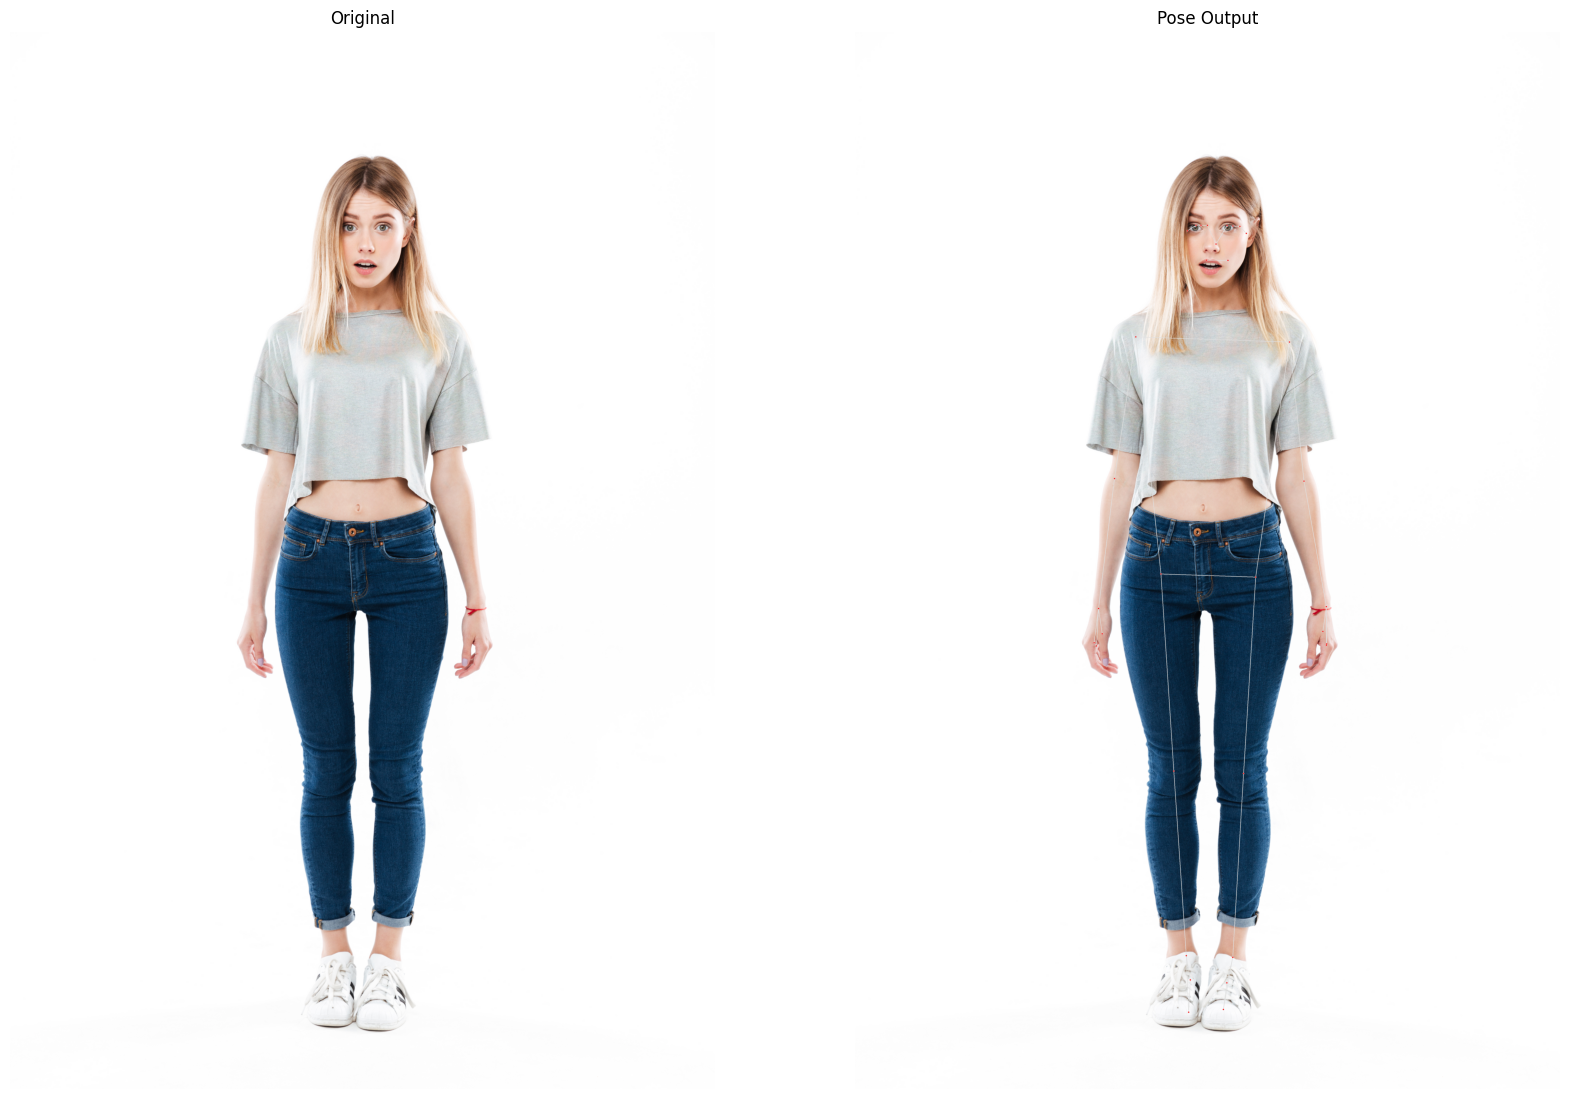

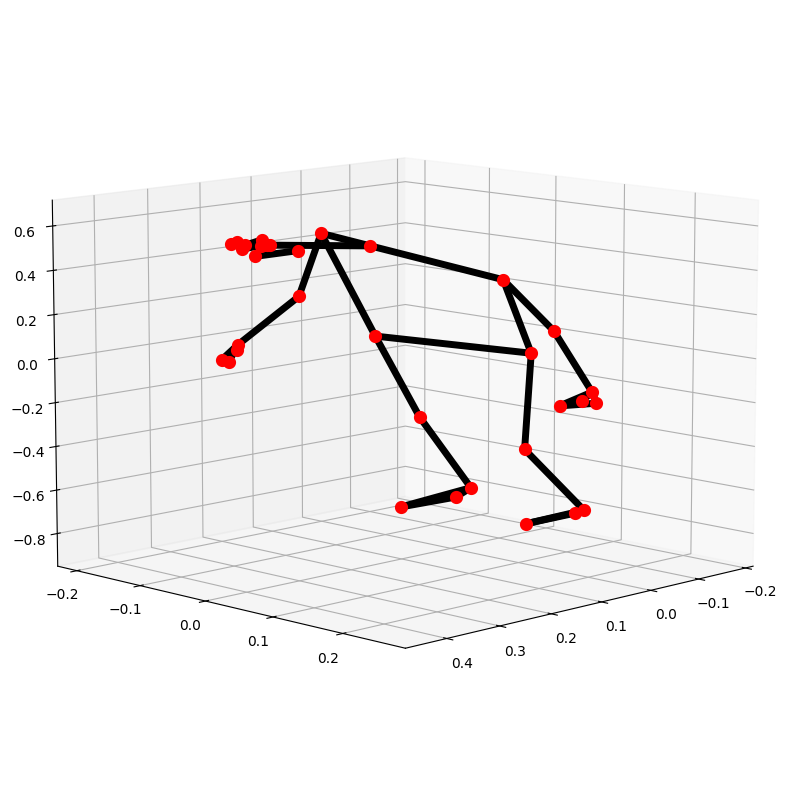

Detected keypoints:
nose: (1966, 1155, -0.9069628119468689)
left_shoulder: (2366, 1689, -0.3264121115207672)
right_shoulder: (1529, 1661, -0.37850114703178406)
left_elbow: (2445, 2447, -0.19884563982486725)
right_elbow: (1413, 2433, -0.33748528361320496)
left_wrist: (2567, 3131, -0.4193125367164612)
right_wrist: (1326, 3141, -0.5732149481773376)
left_hip: (2182, 2970, 0.02344828099012375)
right_hip: (1666, 2953, -0.02393244579434395)
left_knee: (2116, 4040, 0.0458063967525959)
right_knee: (1736, 4027, -0.04428039491176605)
left_ankle: (2057, 5042, 0.3663279414176941)
right_ankle: (1804, 5033, 0.2189209908246994)


In [70]:
output_image, keypoints = detectClothingPose(image, POSE_MODEL, display=True)

In [71]:
print(keypoints)

{'nose': (1966, 1155, -0.9069628119468689), 'left_shoulder': (2366, 1689, -0.3264121115207672), 'right_shoulder': (1529, 1661, -0.37850114703178406), 'left_elbow': (2445, 2447, -0.19884563982486725), 'right_elbow': (1413, 2433, -0.33748528361320496), 'left_wrist': (2567, 3131, -0.4193125367164612), 'right_wrist': (1326, 3141, -0.5732149481773376), 'left_hip': (2182, 2970, 0.02344828099012375), 'right_hip': (1666, 2953, -0.02393244579434395), 'left_knee': (2116, 4040, 0.0458063967525959), 'right_knee': (1736, 4027, -0.04428039491176605), 'left_ankle': (2057, 5042, 0.3663279414176941), 'right_ankle': (1804, 5033, 0.2189209908246994)}


## Warping (사람 + 옷)

### 1. 템플릿 JSON(size.json) 로드

In [72]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

TEMPLATE_JSON_PATH = "/content/drive/MyDrive/컴비 팀플/data/size_3.json"

with open(TEMPLATE_JSON_PATH, "r", encoding="utf-8") as f:
    CLOTH_TEMPLATES = json.load(f)

print("불러온 템플릿 ID들:", list(CLOTH_TEMPLATES.keys()))
# 예: ['hoodie_1', 'jeans_1', 'gown_1']


불러온 템플릿 ID들: ['hoodie_1', 'hoodie_2', 'hoodie_3', 'hoodie_4', 'hoodie_5', 'hoodie_6', 'hoodie_7', 'hoodie_8', 'hoodie_9', 'hoodie_10', 'blazer_1', 'blazer_2', 'blazer_3', 'blazer_4', 'blazer_5', 'blazer_6', 'blazer_7', 'blazer_8', 'blazer_9', 'blazer_10', 'jaket_1', 'jaket_2', 'jaket_3', 'jaket_4', 'jaket_5', 'jaket_6', 'jaket_7', 'jaket_8', 'jaket_9', 'jaket_10', 'kaos_1', 'kaos_2', 'kaos_3', 'kaos_4', 'kaos_5', 'kaos_6', 'kaos_7', 'kaos_8', 'kaos_9', 'kaos_10', 'kemeja_1', 'kemeja_2', 'kemeja_3', 'kemeja_4', 'kemeja_5', 'kemeja_6', 'kemeja_7', 'kemeja_8', 'kemeja_9', 'kemeja_10', 'polo_1', 'polo_2', 'polo_3', 'polo_4', 'polo_5', 'polo_6', 'polo_7', 'polo_8', 'polo_9', 'polo_10', 'sweter_1', 'sweter_2', 'sweter_3', 'sweter_4', 'sweter_5', 'sweter_6', 'sweter_7', 'sweter_8', 'sweter_9', 'sweter_10', 'panjang_1', 'panjang_2', 'panjang_3', 'panjang_4', 'panjang_5', 'panjang_6', 'panjang_7', 'panjang_8', 'panjang_9', 'panjang_10', 'pendek_1', 'pendek_2', 'pendek_3', 'pendek_4', 'pendek_5'

### 2. Warping 유틸 함수들

## Affine 버전

Detected keypoints:
nose: (1966, 1155, -0.9069628119468689)
left_shoulder: (2366, 1689, -0.3264121115207672)
right_shoulder: (1529, 1661, -0.37850114703178406)
left_elbow: (2445, 2447, -0.19884563982486725)
right_elbow: (1413, 2433, -0.33748528361320496)
left_wrist: (2567, 3131, -0.4193125367164612)
right_wrist: (1326, 3141, -0.5732149481773376)
left_hip: (2182, 2970, 0.02344828099012375)
right_hip: (1666, 2953, -0.02393244579434395)
left_knee: (2116, 4040, 0.0458063967525959)
right_knee: (1736, 4027, -0.04428039491176605)
left_ankle: (2057, 5042, 0.3663279414176941)
right_ankle: (1804, 5033, 0.2189209908246994)
src: 
 [[247. 988.]
 [166. 319.]
 [467. 995.]
 [541. 332.]] dst: 
 [[2182. 2970.]
 [2366. 1689.]
 [1666. 2953.]
 [1529. 1661.]]
src: 
 [[ 92. 590.]
 [130. 193.]
 [260. 601.]
 [230. 186.]] dst: 
 [[2057. 5042.]
 [2182. 2970.]
 [1804. 5033.]
 [1666. 2953.]]
src: 
 [[134. 443.]
 [ 87.  76.]
 [229. 448.]
 [303.  54.]] dst: 
 [[2182. 2970.]
 [2366. 1689.]
 [1666. 2953.]
 [1529. 1661

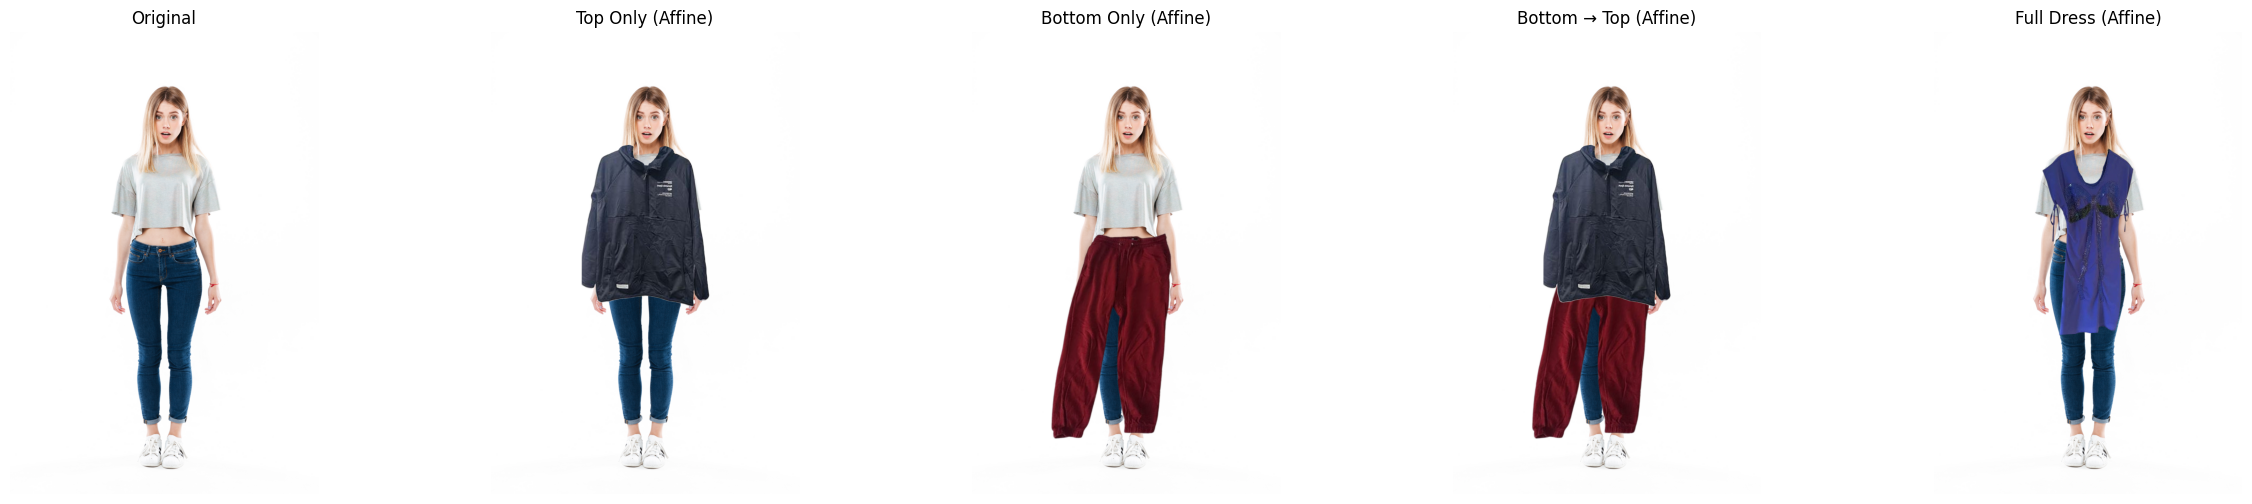

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 0) 공통 유틸
# ------------------------------------------------

def ensure_bgra(cloth_img):
    """3채널이면 알파 채널(255)을 추가해서 BGRA로 맞춰줌."""
    if cloth_img is None:
        raise ValueError("cloth_img 가 None 입니다. 경로를 확인하세요.")
    if cloth_img.shape[2] == 4:
        return cloth_img
    b, g, r = cv2.split(cloth_img)
    a = np.full_like(b, 255)
    return cv2.merge([b, g, r, a])


def get_src_dst_points_from_template(cloth_meta, keypoints, min_points=3):
    """
    옷 템플릿의 anchors(옷 좌표)와
    pose keypoints(사람 좌표)를
    '같은 이름'끼리 매칭해서
    src_pts(옷), dst_pts(사람)을 만든다.
    """
    anchors = cloth_meta["anchors"]

    # 1) 공통으로 존재하는 이름만 사용 (이름 기준 매칭)
    common_names = sorted(set(anchors.keys()) & set(keypoints.keys()))

    if len(common_names) < min_points:
        raise ValueError(
            f"매칭 가능한 공통 포인트가 {min_points}개 미만입니다. "
            f"공통 names={common_names}"
        )

    src_pts, dst_pts = [], []

    # 2) 이름 순서대로 src/dst 쌍을 만든다
    for name in common_names:
        cx, cy = anchors[name]          # 옷 이미지 안 anchor
        px, py, _ = keypoints[name]     # 사람 이미지 안 keypoint

        src_pts.append([cx, cy])
        dst_pts.append([px, py])

    src_pts = np.float32(src_pts)
    dst_pts = np.float32(dst_pts)

    return src_pts, dst_pts


# ------------------------------------------------
# 1) Affine(2x3) 변환으로 옷 입히기
# ------------------------------------------------

def fit_cloth_with_template_affine(person_img_bgr, keypoints, cloth_img, cloth_meta):
    """
    Affine(2x3) 변환으로 옷을 입히는 버전
    - person_img_bgr : 사람 원본 이미지 (BGR)
    - keypoints      : detectClothingPose() 에서 얻은 포즈 키포인트 dict
    - cloth_img      : 옷 PNG (BGR 또는 BGRA)
    - cloth_meta     : size.json 에서 읽은 해당 옷 템플릿(dict)
    """
    ph, pw = person_img_bgr.shape[:2]
    cloth_bgra = ensure_bgra(cloth_img)

    # 1) 옷-사람 기준점 (같은 이름끼리 매칭)
    src_pts, dst_pts = get_src_dst_points_from_template(
        cloth_meta, keypoints, min_points=3
    )

    # 2) Affine 변환 행렬 추정
    if len(src_pts) == 3:
        M = cv2.getAffineTransform(src_pts, dst_pts)  # 3점일 때 전용
    else:
        M, inliers = cv2.estimateAffine2D(src_pts, dst_pts)  # 3점 이상일 때
        if M is None:
            raise RuntimeError("Affine 변환 행렬 추정 실패(estimateAffine2D 결과가 None 입니다).")

    # 3) 옷을 사람 이미지 크기에 맞게 warpAffine
    warped = cv2.warpAffine(
        cloth_bgra, M, (pw, ph),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0, 0)  # 바깥은 투명
    )

    # 4) 알파 블렌딩
    wb, wg, wr, wa = cv2.split(warped)
    cloth_rgb = cv2.merge([wb, wg, wr])
    alpha = wa.astype(np.float32) / 255.0
    alpha_3 = cv2.merge([alpha, alpha, alpha])

    base = person_img_bgr.astype(np.float32)
    out = cloth_rgb.astype(np.float32) * alpha_3 + base * (1.0 - alpha_3)
    out = np.clip(out, 0, 255).astype(np.uint8)

    print("src: \n", src_pts, "dst: \n", dst_pts)
    return out


def fit_from_template_id_affine(person_img_bgr, keypoints, template_id):
    """
    template_id: size.json 에 정의한 키 이름 (예: 'hoodie_1', 'jeans_1', 'gown_1')
    Affine(2x3) 버전
    """
    if template_id not in CLOTH_TEMPLATES:
        raise KeyError(f"size.json 에 '{template_id}' 템플릿이 없습니다.")

    meta = CLOTH_TEMPLATES[template_id]
    img_path = meta["image_path"]

    cloth_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if cloth_img is None:
        raise FileNotFoundError(f"옷 이미지를 찾을 수 없습니다: {img_path}")

    result = fit_cloth_with_template_affine(person_img_bgr, keypoints, cloth_img, meta)
    return result


# ------------------------------------------------
# 2) 예시 실행 (Affine 버전)
# ------------------------------------------------

# 1) 포즈 추출
pose_output, keypoints = detectClothingPose(image, POSE_MODEL, display=False)

# 2) 상의 / 하의 / 원피스 각각 입히기 (Affine)
result_top_affine = fit_from_template_id_affine(
    image,
    keypoints,
    template_id="hoodie_1"    # 상의 템플릿 키
)

result_bottom_affine = fit_from_template_id_affine(
    image,
    keypoints,
    template_id="panjang_1"   # 하의 템플릿 키
)

result_full_affine = fit_from_template_id_affine(
    image,
    keypoints,
    template_id="gaun_1"      # 원피스/가운 템플릿 키
)

# 2-1) 상의 + 하의 (하의 먼저 → 상의 나중) - Affine
result_both_affine = fit_from_template_id_affine(
    image,
    keypoints,
    template_id="panjang_1"
)
result_both_affine = fit_from_template_id_affine(
    result_both_affine,
    keypoints,
    template_id="hoodie_1"
)

# 3) 시각화 (Affine 결과)
plt.figure(figsize=(30, 6))

plt.subplot(151)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(152)
plt.imshow(cv2.cvtColor(result_top_affine, cv2.COLOR_BGR2RGB))
plt.title("Top Only (Affine)")
plt.axis("off")

plt.subplot(153)
plt.imshow(cv2.cvtColor(result_bottom_affine, cv2.COLOR_BGR2RGB))
plt.title("Bottom Only (Affine)")
plt.axis("off")

plt.subplot(154)
plt.imshow(cv2.cvtColor(result_both_affine, cv2.COLOR_BGR2RGB))
plt.title("Bottom → Top (Affine)")
plt.axis("off")

plt.subplot(155)
plt.imshow(cv2.cvtColor(result_full_affine, cv2.COLOR_BGR2RGB))
plt.title("Full Dress (Affine)")
plt.axis("off")

plt.show()


## Homography 버전 + affine + 바지 마스킹

In [89]:
woman_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_front.jpg')
woman_back = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_back.jpg')
woman_left = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_left.jpg')
woman_right = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_right.jpg')

man_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Man_whole_body_front.jpg')
woman2_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/WOMEN-Tees_Tanks-id_00004269-04_1_front.jpg')

image = woman_front

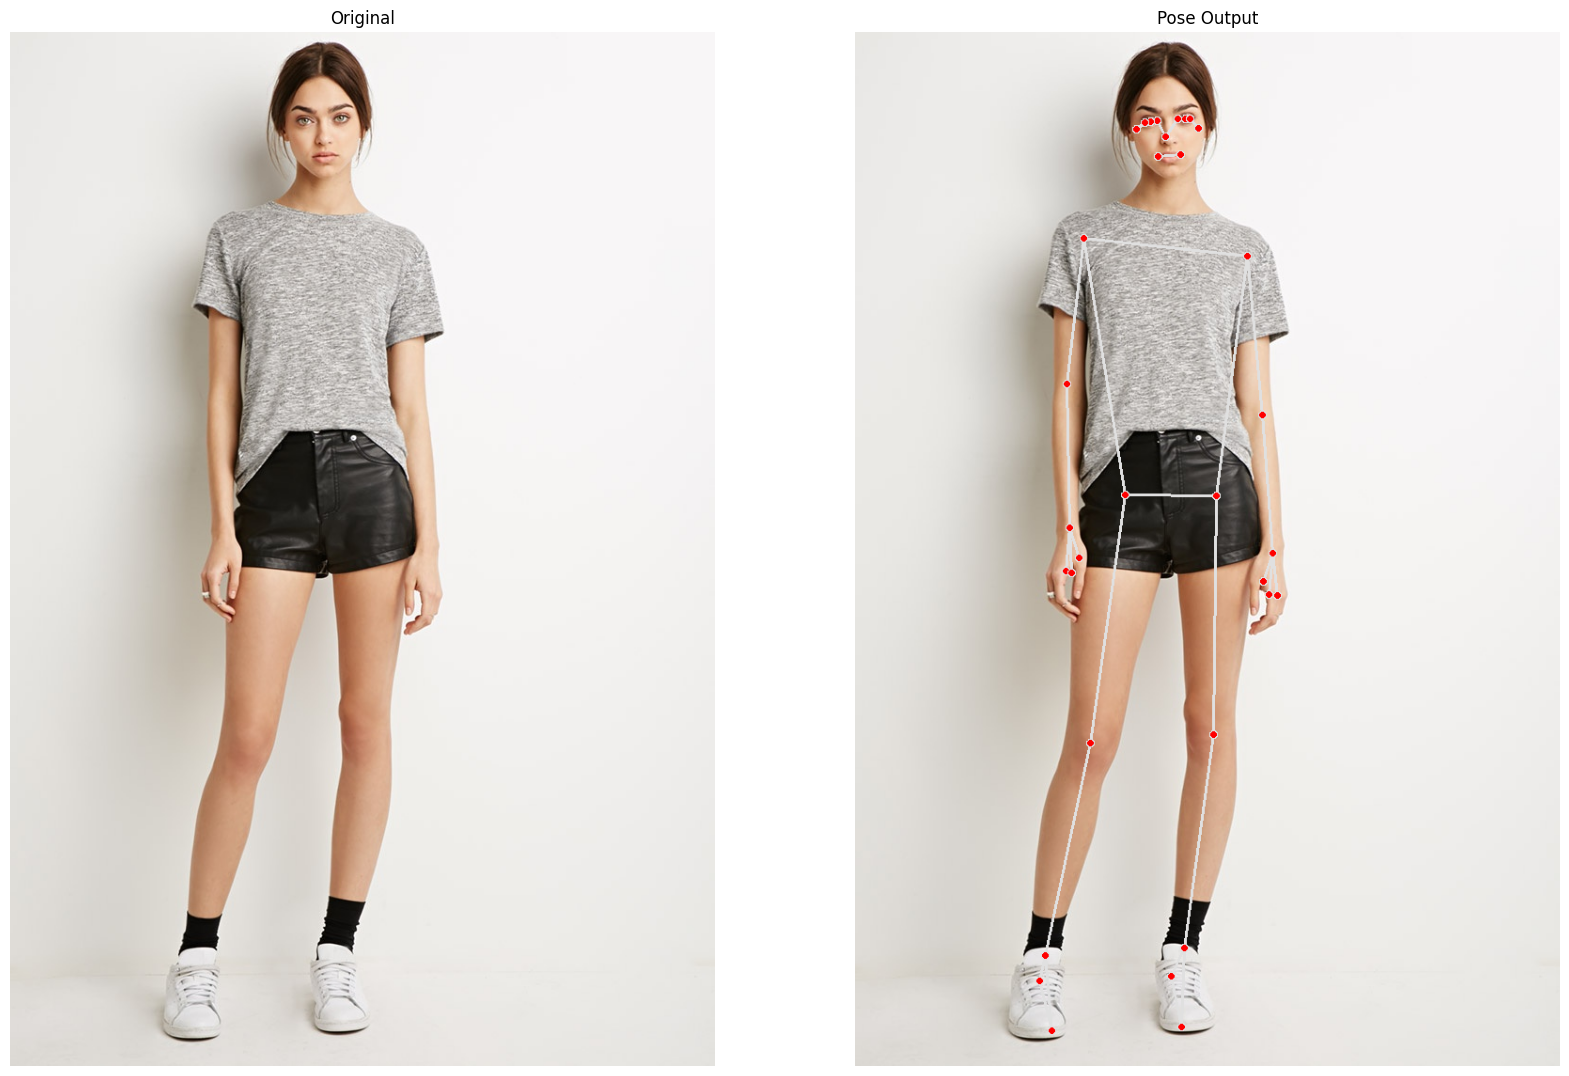

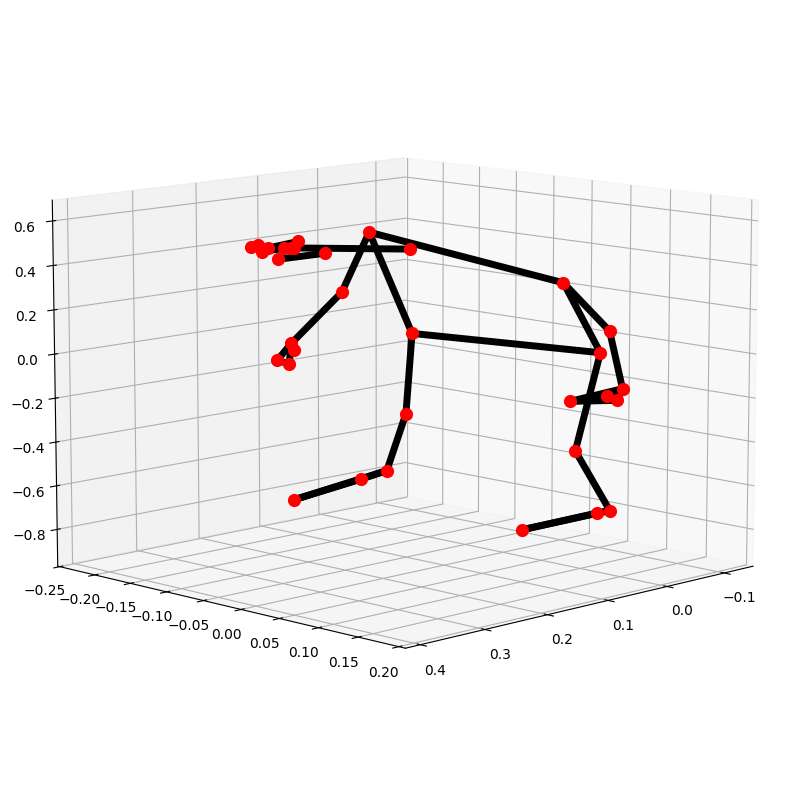

Detected keypoints:
nose: (330, 112, -0.8634363412857056)
left_shoulder: (417, 239, -0.2433411180973053)
right_shoulder: (243, 220, -0.33799421787261963)
left_elbow: (433, 408, -0.09703671932220459)
right_elbow: (225, 375, -0.28808319568634033)
left_wrist: (444, 555, -0.3520793318748474)
right_wrist: (228, 528, -0.5446163415908813)
left_hip: (384, 494, 0.05208645015954971)
right_hip: (287, 493, -0.052738454192876816)
left_knee: (381, 748, 0.021113669499754906)
right_knee: (250, 757, -0.1211613193154335)
left_ankle: (350, 975, 0.2882383167743683)
right_ankle: (202, 983, 0.07894885540008545)


In [76]:
output_image, keypoints = detectClothingPose(image, POSE_MODEL, display=True)

### 1. 템플릿 JSON(size.json) 로드

In [120]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

TEMPLATE_JSON_PATH = "/content/drive/MyDrive/컴비 팀플/data/pants_anchors.json"
# TEMPLATE_JSON_PATH = "/content/drive/MyDrive/컴비 팀플/data/size.json"

with open(TEMPLATE_JSON_PATH, "r", encoding="utf-8") as f:
    CLOTH_TEMPLATES = json.load(f)

print("불러온 템플릿 ID들:", list(CLOTH_TEMPLATES.keys()))
# 예: ['hoodie_1', 'jeans_1', 'gown_1']


불러온 템플릿 ID들: ['hoodie_1', 'hoodie_2', 'sweter_4', 'panjang_1', 'panjang_2', 'panjang_5', 'gaun_1', 'gaun_2', 'mantel_5', 'mantel_9']


### 2. Warping 유틸 함수들

In [110]:
def ensure_bgra(cloth_img):
    """3채널이면 알파 채널(255)을 추가해서 BGRA로 맞춰줌."""
    if cloth_img is None:
        raise ValueError("cloth_img 가 None 입니다. 경로를 확인하세요.")
    if cloth_img.shape[2] == 4:
        return cloth_img
    b, g, r = cv2.split(cloth_img)
    a = np.full_like(b, 255)
    return cv2.merge([b, g, r, a])

def make_leg_mask(shape, hip, knee, ankle, width):
    """
    단순 사각형 기반 다리 마스크
    """
    mask = np.zeros(shape[:2], dtype=np.uint8)

    pts = np.array([
        [hip[0] - width, hip[1]],
        [hip[0] + width, hip[1]],
        [ankle[0] + width, ankle[1]],
        [ankle[0] - width, ankle[1]],
    ], dtype=np.int32)

    cv2.fillConvexPoly(mask, pts, 255)
    return mask

def crop_leg_region(cloth_bgra, hip, knee, ankle, padding=30):
    """
    바지 이미지에서 한쪽 다리만 crop
    hip, knee, ankle: cloth 좌표계
    """
    xs = [hip[0], knee[0], ankle[0]]
    ys = [hip[1], knee[1], ankle[1]]

    x_min = max(0, min(xs) - padding)
    x_max = min(cloth_bgra.shape[1], max(xs) + padding)
    y_min = max(0, min(ys) - padding)
    y_max = min(cloth_bgra.shape[0], max(ys) + padding)

    cropped = cloth_bgra[y_min:y_max, x_min:x_max].copy()

    offset = (x_min, y_min)
    return cropped, offset

def get_src_dst_points_from_template(cloth_meta, keypoints):
    """
    size.json 의 anchors(옷 좌표)와
    pose keypoints(사람 좌표)를 매칭해서
    src_pts(옷), dst_pts(사람) 배열을 만들기
    """
    src_pts, dst_pts = [], []

    for name, pos in cloth_meta["anchors"].items():
        if name not in keypoints:
            # 이 키포인트는 pose에서 못 찾았으면 스킵
            continue

        cx, cy = pos              # 옷 이미지 안에서의 anchor
        px, py, _ = keypoints[name]  # 사람 이미지 안에서의 keypoint

        src_pts.append([cx, cy])
        dst_pts.append([px, py])

    src_pts = np.float32(src_pts)
    dst_pts = np.float32(dst_pts)

    if len(src_pts) < 3:
        raise ValueError(f"매칭 가능한 포인트가 3개 미만입니다. anchors: {cloth_meta['anchors'].keys()}")

    return src_pts, dst_pts


## ----- 교수님 Homograpy + RANSAC 방식 적용 -----
def fit_cloth_with_template(person_img_bgr, keypoints, cloth_img, cloth_meta):
    """
    - person_img_bgr : 사람 원본 이미지 (BGR)
    - keypoints      : detectClothingPose() 에서 얻은 포즈 키포인트 dict
    - cloth_img      : 옷 PNG (BGR 또는 BGRA)
    - cloth_meta     : size.json 에서 읽은 해당 옷 템플릿(dict)
    """
    ph, pw = person_img_bgr.shape[:2]
    cloth_bgra = ensure_bgra(cloth_img)

    # === (1) src / dst 포인트 ===
    src_pts, dst_pts = get_src_dst_points_from_template(cloth_meta, keypoints)

    # 포인트 개수 체크
    if len(src_pts) < 4:
        raise ValueError("Homography는 최소 4개 대응점이 필요합니다.")

    # === (2) Homography (교수님 코드 핵심) ===
    H, inlier_mask = cv2.findHomography(
        src_pts,
        dst_pts,
        method=cv2.RANSAC,
        ransacReprojThreshold=5.0
    )

    if H is None:
        raise RuntimeError("Homography 계산 실패")

    # === (3) warpPerspective ===
    warped = cv2.warpPerspective(
        cloth_bgra,
        H,
        (pw, ph),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0, 0)
    )

    # === (4) 알파 블렌딩 ===
    wb, wg, wr, wa = cv2.split(warped)
    cloth_rgb = cv2.merge([wb, wg, wr])

    alpha = wa.astype(np.float32) / 255.0
    alpha = cv2.GaussianBlur(alpha, (0, 0), 1.5)
    alpha_3 = cv2.merge([alpha, alpha, alpha])

    base = person_img_bgr.astype(np.float32)
    out = cloth_rgb.astype(np.float32) * alpha_3 + base * (1.0 - alpha_3)
    out = np.clip(out, 0, 255).astype(np.uint8)

    return out

In [93]:
def alpha_blend_bgra(base_bgra, overlay_bgra, blur_sigma=1.2):
    """
    base_bgra, overlay_bgra: BGRA 이미지
    overlay를 base 위에 알파 블렌딩
    """
    # overlay 분리
    ob, og, or_, oa = cv2.split(overlay_bgra)
    overlay_rgb = cv2.merge([ob, og, or_])

    alpha = oa.astype(np.float32) / 255.0
    alpha = cv2.GaussianBlur(alpha, (0, 0), blur_sigma)
    alpha_3 = cv2.merge([alpha, alpha, alpha])

    base_rgb = base_bgra[:, :, :3].astype(np.float32)

    out_rgb = overlay_rgb.astype(np.float32) * alpha_3 \
            + base_rgb * (1.0 - alpha_3)

    out = base_bgra.copy()
    out[:, :, :3] = np.clip(out_rgb, 0, 255).astype(np.uint8)
    out[:, :, 3] = np.maximum(base_bgra[:, :, 3], oa)

    return out

### 3. 템플릿 ID로 바로 피팅하는 함수

In [94]:
def fit_bottom_piecewise(person_img_bgr, keypoints, cloth_img, cloth_meta):
    cloth_bgra = ensure_bgra(cloth_img)
    ph, pw = person_img_bgr.shape[:2]

    canvas = np.zeros((ph, pw, 4), dtype=np.uint8)

    hip_dist = abs(keypoints["left_hip"][0] - keypoints["right_hip"][0])
    width_px = max(15, int(0.12 * hip_dist))

    for side, sign in [("left", 1), ("right", -1)]:

        # ---------- 사람 좌표 ----------
        dst_hip   = keypoints[f"{side}_hip"][:2]
        dst_knee  = keypoints[f"{side}_knee"][:2]
        dst_ankle = keypoints[f"{side}_ankle"][:2]

        # ---------- 옷 좌표 ----------
        src_hip   = cloth_meta["anchors"][f"{side}_hip"]
        src_knee  = cloth_meta["anchors"][f"{side}_knee"]
        src_ankle = cloth_meta["anchors"][f"{side}_ankle"]

        # ---------- 1. 다리 crop ----------
        leg_crop, (ox, oy) = crop_leg_region(
            cloth_bgra, src_hip, src_knee, src_ankle
        )

        # crop 좌표계로 변환
        src_hip_c   = (src_hip[0] - ox, src_hip[1] - oy)
        src_ankle_c = (src_ankle[0] - ox, src_ankle[1] - oy)

        # ---------- 2. affine ----------
        src_pts = np.float32([
            src_hip_c,
            src_ankle_c,
            [src_hip_c[0] + sign * width_px, src_hip_c[1]]
        ])
        dst_pts = np.float32([
            dst_hip,
            dst_ankle,
            [dst_hip[0] + sign * width_px, dst_hip[1]]
        ])

        M = cv2.getAffineTransform(src_pts, dst_pts)

        warped = cv2.warpAffine(
            leg_crop, M, (pw, ph),
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0,0,0,0)
        )

        # ---------- 3. 합성 ----------
        canvas = alpha_blend_bgra(canvas, warped)

    # ---------- 최종 ----------
    final = alpha_blend_bgra(
        ensure_bgra(person_img_bgr),
        canvas
    )

    return final[:, :, :3]

In [95]:
def fit_from_template_id(person_img_bgr, keypoints, template_id):
    meta = CLOTH_TEMPLATES[template_id]
    cloth_img = cv2.imread(meta["image_path"], cv2.IMREAD_UNCHANGED)

    if meta["category"] == "bottom":
        return fit_bottom_piecewise(
            person_img_bgr, keypoints, cloth_img, meta
        )

    # 상의 / 원피스
    return fit_cloth_with_template(
        person_img_bgr, keypoints, cloth_img, meta
    )

### 4. 적용: 상의 / 하의 / 원피스 각각 + 오리지널 (4장 시각화)

Detected keypoints:
nose: (330, 112, -0.8634363412857056)
left_shoulder: (417, 239, -0.2433411180973053)
right_shoulder: (243, 220, -0.33799421787261963)
left_elbow: (433, 408, -0.09703671932220459)
right_elbow: (225, 375, -0.28808319568634033)
left_wrist: (444, 555, -0.3520793318748474)
right_wrist: (228, 528, -0.5446163415908813)
left_hip: (384, 494, 0.05208645015954971)
right_hip: (287, 493, -0.052738454192876816)
left_knee: (381, 748, 0.021113669499754906)
right_knee: (250, 757, -0.1211613193154335)
left_ankle: (350, 975, 0.2882383167743683)
right_ankle: (202, 983, 0.07894885540008545)


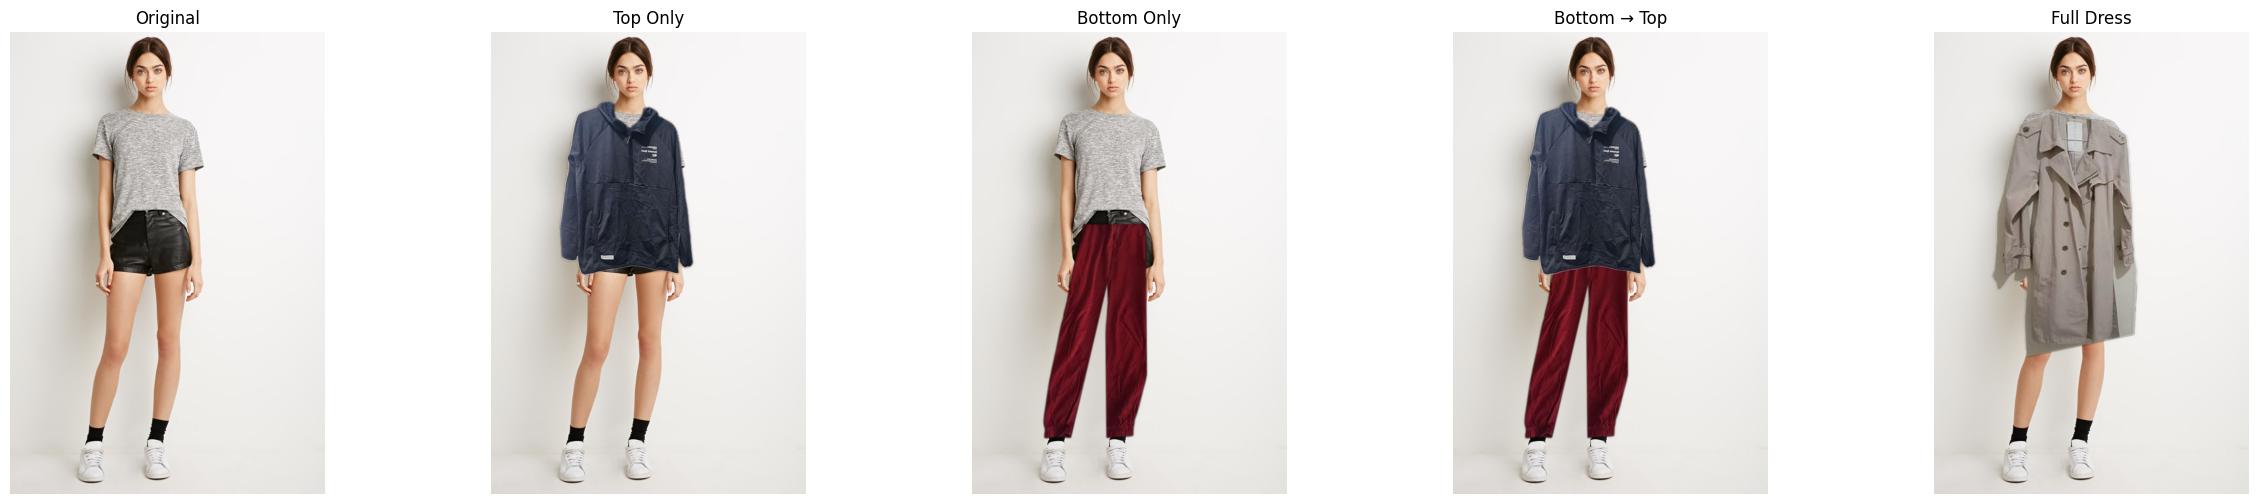

In [121]:
# 1) 포즈 추출
pose_output, keypoints = detectClothingPose(image, POSE_MODEL, display=False)

# 2) 상의 / 하의 / 원피스 각각 입히기
result_top = fit_from_template_id(
    image,
    keypoints,
    template_id="hoodie_1"    # 상의 템플릿 키
)

result_bottom = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_1"   # 하의 템플릿 키
)

result_full = fit_from_template_id(
    image,
    keypoints,
    template_id="mantel_9"      # 원피스/가운 템플릿 키
)

# 2-1) 상의 + 하의 버전 (하의 먼저 → 상의 나중)
result_both = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_1"   # 먼저 하의
)
result_both = fit_from_template_id(
    result_both,
    keypoints,
    template_id="hoodie_1"    # 그 위에 상의
)

# 3) 결과 시각화
plt.figure(figsize=(30, 6))

plt.subplot(151)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(152)
plt.imshow(cv2.cvtColor(result_top, cv2.COLOR_BGR2RGB))
plt.title("Top Only")
plt.axis("off")

plt.subplot(153)
plt.imshow(cv2.cvtColor(result_bottom, cv2.COLOR_BGR2RGB))
plt.title("Bottom Only")
plt.axis("off")

plt.subplot(154)
plt.imshow(cv2.cvtColor(result_both, cv2.COLOR_BGR2RGB))
plt.title("Bottom → Top")
plt.axis("off")

plt.subplot(155)
plt.imshow(cv2.cvtColor(result_full, cv2.COLOR_BGR2RGB))
plt.title("Full Dress")
plt.axis("off")

plt.show()


Detected keypoints:
nose: (330, 112, -0.8634363412857056)
left_shoulder: (417, 239, -0.2433411180973053)
right_shoulder: (243, 220, -0.33799421787261963)
left_elbow: (433, 408, -0.09703671932220459)
right_elbow: (225, 375, -0.28808319568634033)
left_wrist: (444, 555, -0.3520793318748474)
right_wrist: (228, 528, -0.5446163415908813)
left_hip: (384, 494, 0.05208645015954971)
right_hip: (287, 493, -0.052738454192876816)
left_knee: (381, 748, 0.021113669499754906)
right_knee: (250, 757, -0.1211613193154335)
left_ankle: (350, 975, 0.2882383167743683)
right_ankle: (202, 983, 0.07894885540008545)


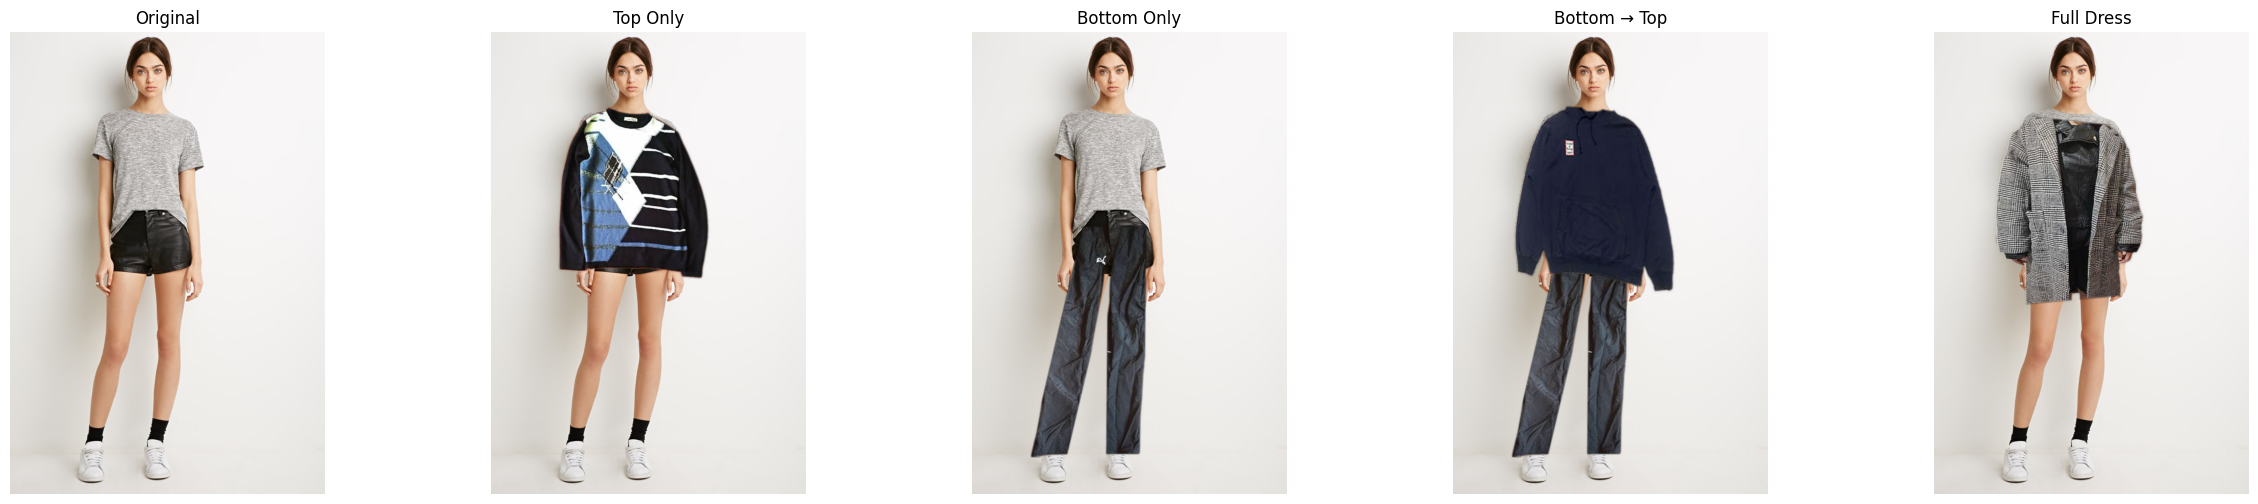

In [122]:
# 1) 포즈 추출
pose_output, keypoints = detectClothingPose(image, POSE_MODEL, display=False)

# 2) 상의 / 하의 / 원피스 각각 입히기
result_top = fit_from_template_id(
    image,
    keypoints,
    template_id="sweter_4"    # 상의 템플릿 키
)

result_bottom = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_5"   # 하의 템플릿 키
)

result_full = fit_from_template_id(
    image,
    keypoints,
    template_id="mantel_5"      # 원피스/가운 템플릿 키
)

# 2-1) 상의 + 하의 버전 (하의 먼저 → 상의 나중)
result_both = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_5"   # 먼저 하의
)
result_both = fit_from_template_id(
    result_both,
    keypoints,
    template_id="hoodie_2"    # 그 위에 상의
)

# 3) 결과 시각화
plt.figure(figsize=(30, 6))

plt.subplot(151)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(152)
plt.imshow(cv2.cvtColor(result_top, cv2.COLOR_BGR2RGB))
plt.title("Top Only")
plt.axis("off")

plt.subplot(153)
plt.imshow(cv2.cvtColor(result_bottom, cv2.COLOR_BGR2RGB))
plt.title("Bottom Only")
plt.axis("off")

plt.subplot(154)
plt.imshow(cv2.cvtColor(result_both, cv2.COLOR_BGR2RGB))
plt.title("Bottom → Top")
plt.axis("off")

plt.subplot(155)
plt.imshow(cv2.cvtColor(result_full, cv2.COLOR_BGR2RGB))
plt.title("Full Dress")
plt.axis("off")

plt.show()

In [123]:
woman_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_front.jpg')
woman_back = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_back.jpg')
woman_left = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_left.jpg')
woman_right = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_right.jpg')

man_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Man_whole_body_front.jpg')
woman2_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/WOMEN-Tees_Tanks-id_00004269-04_1_front.jpg')

image = man_front

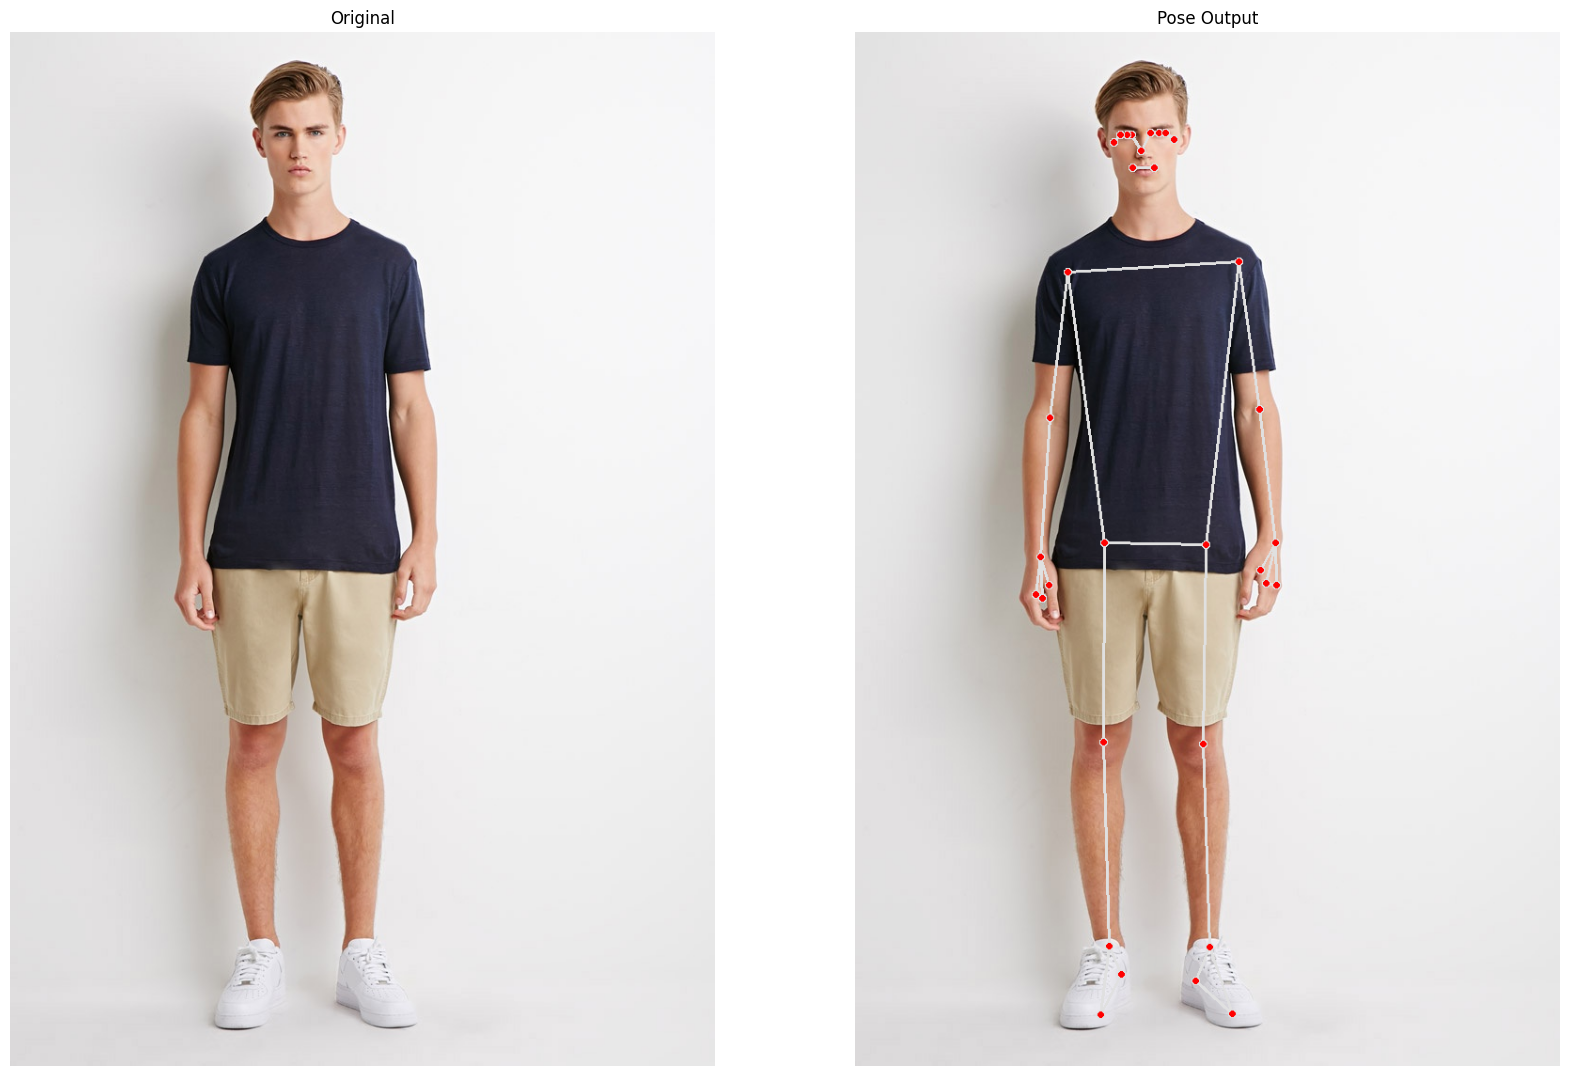

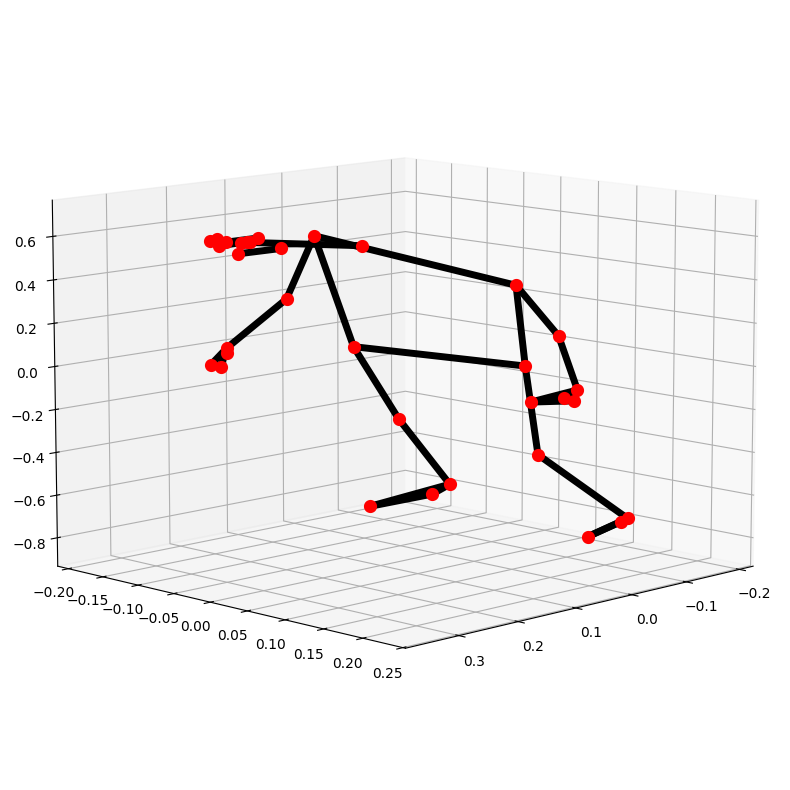

Detected keypoints:
nose: (304, 127, -0.6884193420410156)
left_shoulder: (408, 245, -0.18846769630908966)
right_shoulder: (226, 256, -0.22101148962974548)
left_elbow: (430, 402, -0.11282464861869812)
right_elbow: (207, 411, -0.20766232907772064)
left_wrist: (447, 544, -0.36069050431251526)
right_wrist: (197, 559, -0.4608909785747528)
left_hip: (373, 546, 0.02564758062362671)
right_hip: (265, 544, -0.02622475102543831)
left_knee: (370, 758, 0.11279286444187164)
right_knee: (264, 756, 0.005066011566668749)
left_ankle: (377, 974, 0.42887893319129944)
right_ankle: (270, 973, 0.27477118372917175)


In [124]:
output_image, keypoints = detectClothingPose(image, POSE_MODEL, display=True)

Detected keypoints:
nose: (304, 127, -0.6884193420410156)
left_shoulder: (408, 245, -0.18846769630908966)
right_shoulder: (226, 256, -0.22101148962974548)
left_elbow: (430, 402, -0.11282464861869812)
right_elbow: (207, 411, -0.20766232907772064)
left_wrist: (447, 544, -0.36069050431251526)
right_wrist: (197, 559, -0.4608909785747528)
left_hip: (373, 546, 0.02564758062362671)
right_hip: (265, 544, -0.02622475102543831)
left_knee: (370, 758, 0.11279286444187164)
right_knee: (264, 756, 0.005066011566668749)
left_ankle: (377, 974, 0.42887893319129944)
right_ankle: (270, 973, 0.27477118372917175)


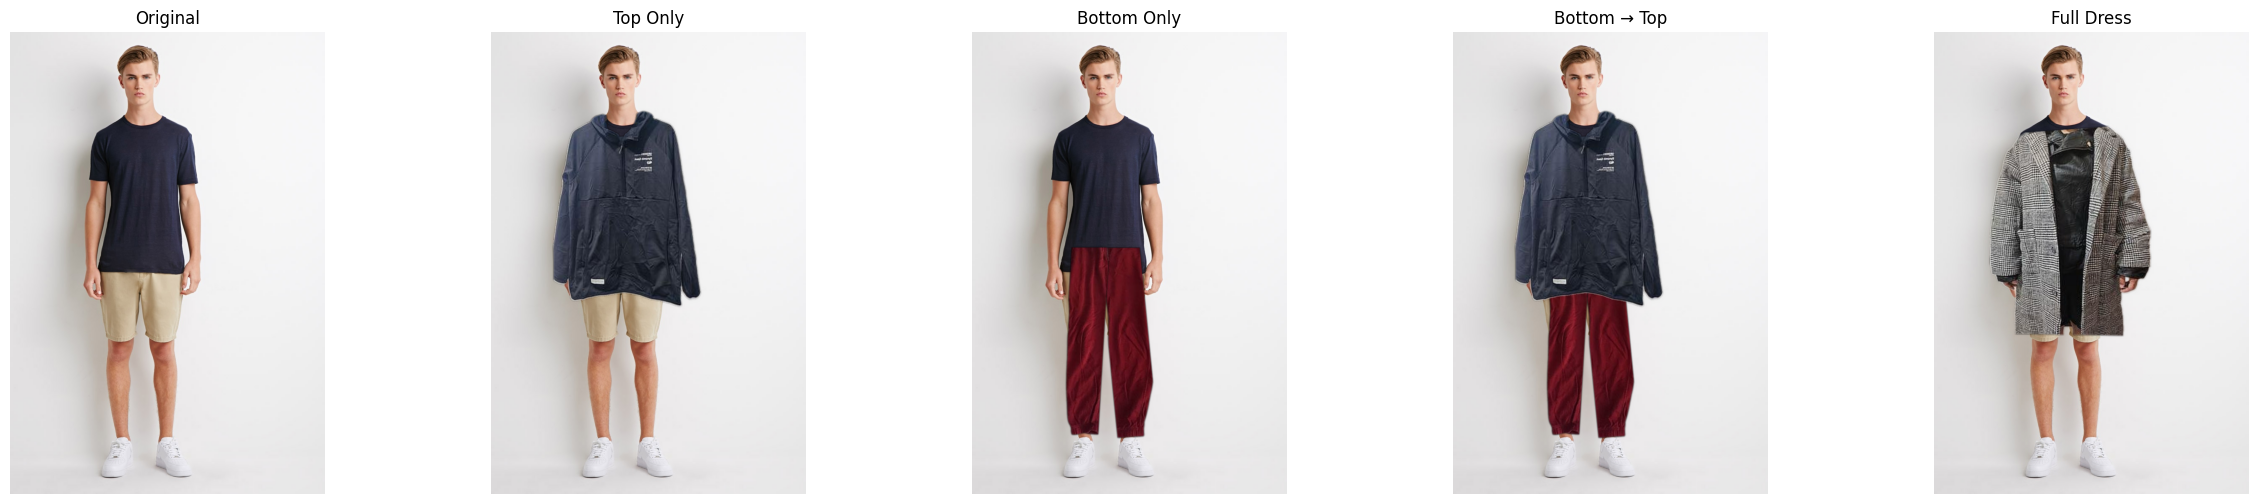

In [126]:
# 1) 포즈 추출
pose_output, keypoints = detectClothingPose(image, POSE_MODEL, display=False)

# 2) 상의 / 하의 / 원피스 각각 입히기
result_top = fit_from_template_id(
    image,
    keypoints,
    template_id="hoodie_1"    # 상의 템플릿 키
)

result_bottom = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_1"   # 하의 템플릿 키
)

result_full = fit_from_template_id(
    image,
    keypoints,
    template_id="mantel_5"      # 원피스/가운 템플릿 키
)

# 2-1) 상의 + 하의 버전 (하의 먼저 → 상의 나중)
result_both = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_1"   # 먼저 하의
)
result_both = fit_from_template_id(
    result_both,
    keypoints,
    template_id="hoodie_1"    # 그 위에 상의
)

# 3) 결과 시각화
plt.figure(figsize=(30, 6))

plt.subplot(151)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(152)
plt.imshow(cv2.cvtColor(result_top, cv2.COLOR_BGR2RGB))
plt.title("Top Only")
plt.axis("off")

plt.subplot(153)
plt.imshow(cv2.cvtColor(result_bottom, cv2.COLOR_BGR2RGB))
plt.title("Bottom Only")
plt.axis("off")

plt.subplot(154)
plt.imshow(cv2.cvtColor(result_both, cv2.COLOR_BGR2RGB))
plt.title("Bottom → Top")
plt.axis("off")

plt.subplot(155)
plt.imshow(cv2.cvtColor(result_full, cv2.COLOR_BGR2RGB))
plt.title("Full Dress")
plt.axis("off")

plt.show()


Detected keypoints:
nose: (304, 127, -0.6884193420410156)
left_shoulder: (408, 245, -0.18846769630908966)
right_shoulder: (226, 256, -0.22101148962974548)
left_elbow: (430, 402, -0.11282464861869812)
right_elbow: (207, 411, -0.20766232907772064)
left_wrist: (447, 544, -0.36069050431251526)
right_wrist: (197, 559, -0.4608909785747528)
left_hip: (373, 546, 0.02564758062362671)
right_hip: (265, 544, -0.02622475102543831)
left_knee: (370, 758, 0.11279286444187164)
right_knee: (264, 756, 0.005066011566668749)
left_ankle: (377, 974, 0.42887893319129944)
right_ankle: (270, 973, 0.27477118372917175)


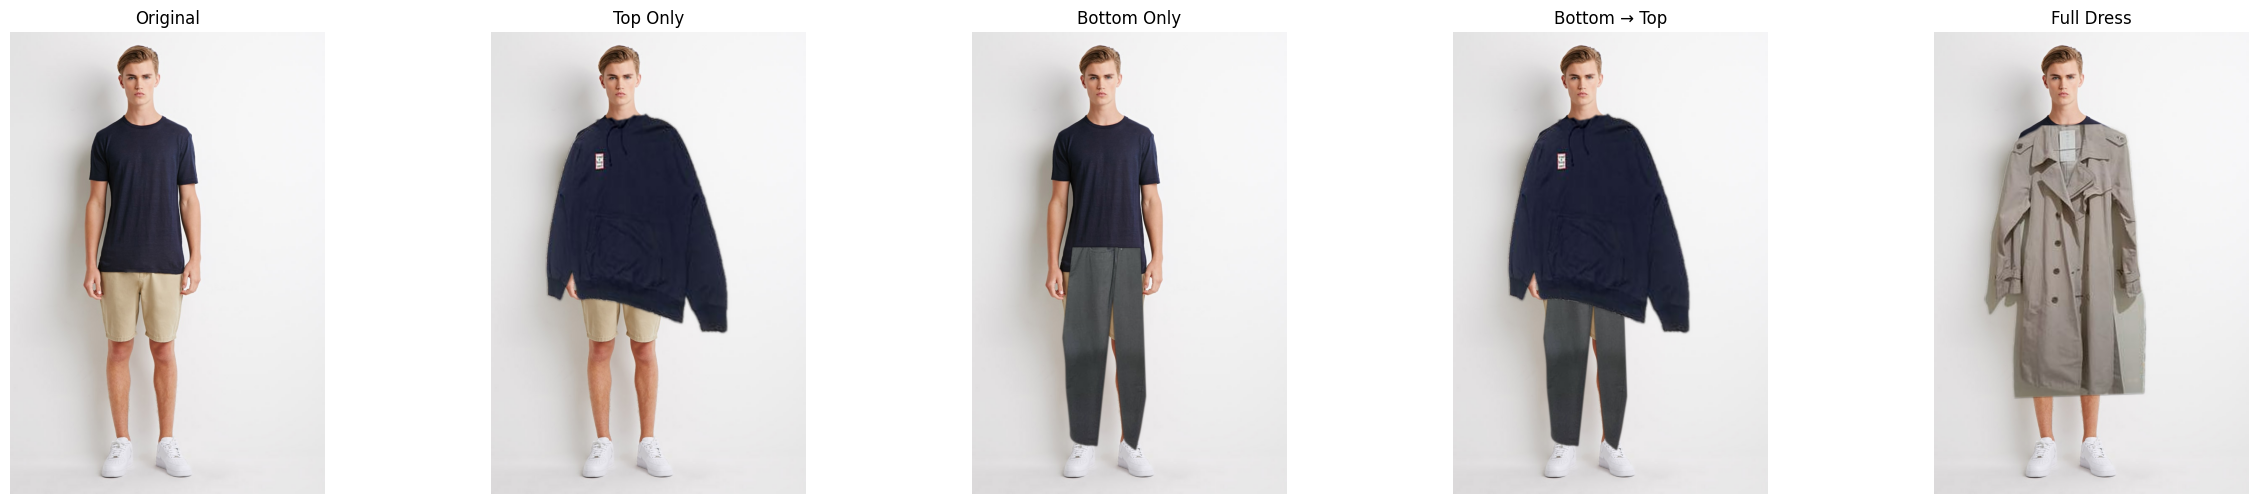

In [133]:
# 1) 포즈 추출
pose_output, keypoints = detectClothingPose(image, POSE_MODEL, display=False)

# 2) 상의 / 하의 / 원피스 각각 입히기
result_top = fit_from_template_id(
    image,
    keypoints,
    template_id="hoodie_2"    # 상의 템플릿 키
)

result_bottom = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_2"   # 하의 템플릿 키
)

result_full = fit_from_template_id(
    image,
    keypoints,
    template_id="mantel_9"      # 원피스/가운 템플릿 키
)

# 2-1) 상의 + 하의 버전 (하의 먼저 → 상의 나중)
result_both = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_2"   # 먼저 하의
)
result_both = fit_from_template_id(
    result_both,
    keypoints,
    template_id="hoodie_2"    # 그 위에 상의
)

# 3) 결과 시각화
plt.figure(figsize=(30, 6))

plt.subplot(151)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(152)
plt.imshow(cv2.cvtColor(result_top, cv2.COLOR_BGR2RGB))
plt.title("Top Only")
plt.axis("off")

plt.subplot(153)
plt.imshow(cv2.cvtColor(result_bottom, cv2.COLOR_BGR2RGB))
plt.title("Bottom Only")
plt.axis("off")

plt.subplot(154)
plt.imshow(cv2.cvtColor(result_both, cv2.COLOR_BGR2RGB))
plt.title("Bottom → Top")
plt.axis("off")

plt.subplot(155)
plt.imshow(cv2.cvtColor(result_full, cv2.COLOR_BGR2RGB))
plt.title("Full Dress")
plt.axis("off")

plt.show()